In [7]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import datetime as dt
import holidays
from lightgbm import LGBMRegressor
import lightgbm as lgb
from sklearn import metrics
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_log_error
from sklearn.model_selection import (
    KFold,
    RandomizedSearchCV,
    StratifiedKFold,
    RepeatedKFold,
    cross_val_score,
    train_test_split,
)
import shap

def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

SEED = 0
plt.style.use('fivethirtyeight')
warnings.filterwarnings("ignore", category=FutureWarning)
plt.style.use("fast")

In [8]:
train_df = pd.read_csv("C:/Users/atalb/Documents/Coding/MLandAI/MLPracticeExercises/Datasets/StickerSales/train.csv", parse_dates=['date']).drop(columns = "id")
test_df = pd.read_csv("C:/Users/atalb/Documents/Coding/MLandAI/MLPracticeExercises/Datasets/StickerSales/test.csv", parse_dates=['date']).drop(columns = "id")
# sample_submission = pd.read_csv("/kaggle/input/playground-series-s5e1/sample_submission.csv")

In [9]:
print("train Data", train_df.info(),"\n\n**********************\n")
print("test Data", test_df.info(),"\n\n**********************")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230130 entries, 0 to 230129
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   date      230130 non-null  datetime64[ns]
 1   country   230130 non-null  object        
 2   store     230130 non-null  object        
 3   product   230130 non-null  object        
 4   num_sold  221259 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 8.8+ MB
train Data None 

**********************

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98550 entries, 0 to 98549
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     98550 non-null  datetime64[ns]
 1   country  98550 non-null  object        
 2   store    98550 non-null  object        
 3   product  98550 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 3.0+ MB
test Data N

In [10]:
train_df.isna().sum()

date           0
country        0
store          0
product        0
num_sold    8871
dtype: int64

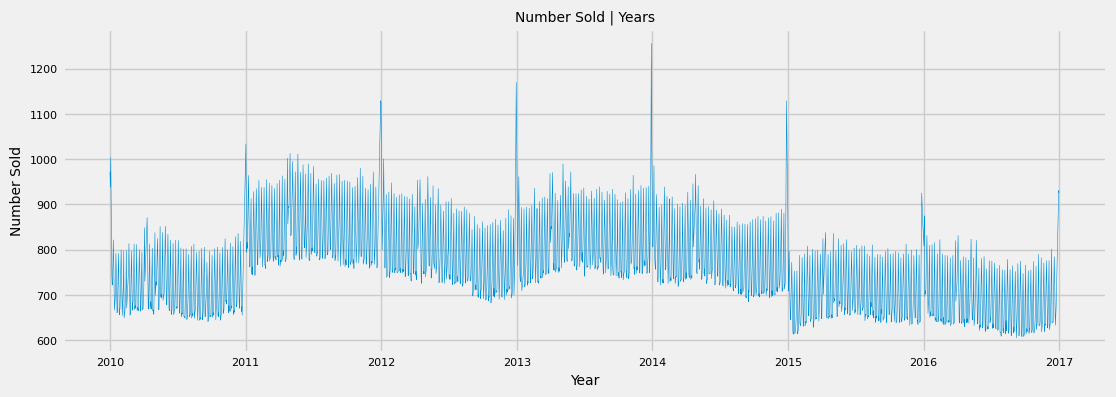

In [11]:
plt.figure(figsize=(12, 4))
ax = sns.lineplot(
    data=train_df,
    x="date",
    y="num_sold",
    errorbar=None,
    linewidth=0.4
)
ax.set_xlabel("Year", fontsize=10)
ax.set_ylabel("Number Sold", fontsize=10)
ax.tick_params(axis="both", labelsize=8)
plt.title("Number Sold | Years", size=10)
plt.show()

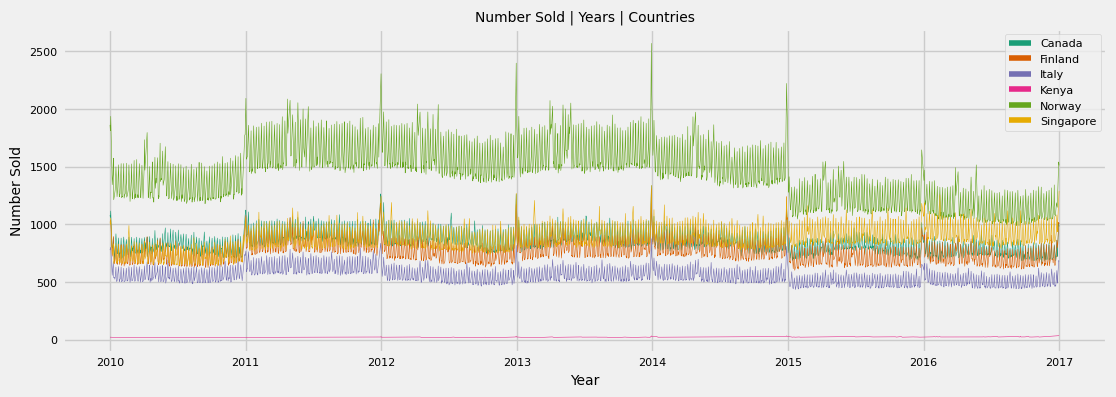

In [12]:
plt.figure(figsize=(12, 4))
ax = sns.lineplot(
    data=train_df,
    x="date",
    y="num_sold",
    hue="country",
    errorbar=None,
    linewidth=0.4,
    palette = "Dark2"
)
ax.set_xlabel("Year", fontsize=10)
ax.set_ylabel("Number Sold", fontsize=10)
ax.tick_params(axis="both", labelsize=8)
ax.legend(bbox_to_anchor=(1, 1), ncols=1, fontsize=8)
plt.title("Number Sold | Years | Countries", size=10)
plt.show()

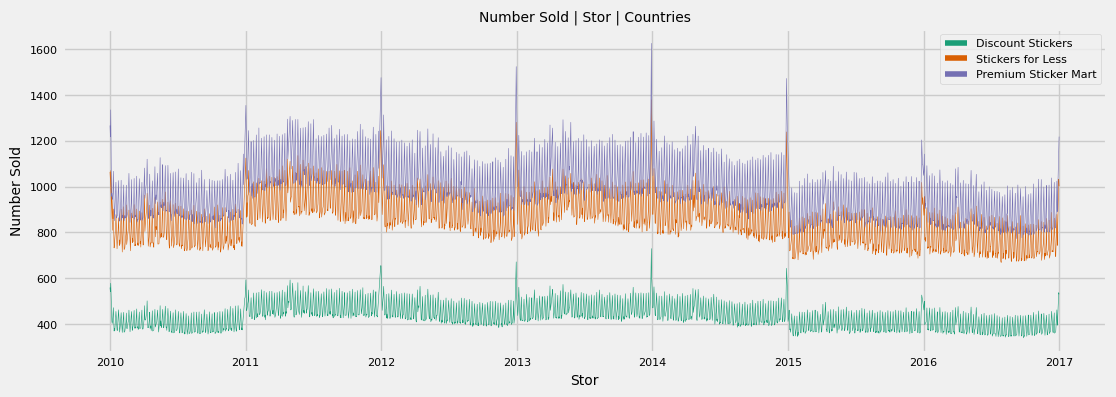

In [13]:
plt.figure(figsize=(12, 4))
ax = sns.lineplot(
    data=train_df,
    x="date",
    y="num_sold",
    hue="store",
    errorbar=None,
    linewidth=0.4,
    palette = "Dark2"
)
ax.set_xlabel("Stor", fontsize=10)
ax.set_ylabel("Number Sold", fontsize=10)
ax.tick_params(axis="both", labelsize=8)
ax.legend(bbox_to_anchor=(1, 1), ncols=1, fontsize=8)
plt.title("Number Sold | Stor | Countries", size=10)
plt.show()

In [14]:
def trans_df(df):
    ## Add Holidays
    extract_country = dict(
        zip(np.sort(df.country.unique()), ["CA", "FI", "IT", "KE", "NO", "SG"]))
    holidays_dict = {
        c: holidays.country_holidays(a, years=range(2010, 2020))
        for c, a in extract_country.items()
    }
    df["is_holiday"] = 0
    for c in holidays_dict:
        df.loc[df.country == c, "is_holiday"] = df.date.isin(holidays_dict[c]).astype(int)

    
    df["weekday_sv"] = df["date"].dt.strftime("%a").astype("category")
    df["weekday_num"] = df["date"].dt.strftime("%w").astype("int")
    df["day_of_month"] = df["date"].dt.strftime("%d").astype("int")
    df["month_name_sv"] = df["date"].dt.strftime("%b").astype("category")
    df["month_num"] = df["date"].dt.strftime("%m").astype("int")
    df["year_fv"] = df["date"].dt.strftime("%Y").astype("int")
    df["day_number_year"] = df["date"].dt.strftime("%j").astype("int")
    df["week_number_year"] = df["date"].dt.strftime("%W").astype("int")
    df["country"] = df["country"].astype("category")
    df["store"] = df["store"].astype("category")
    df["product"] = df["product"].astype("category")
    df["is_holiday"] = df["is_holiday"].astype("int")
    df["year_sin"] = np.sin(2 * np.pi * df["year_fv"]/3)
    df["year_cos"] = np.cos(2 * np.pi * df["year_fv"]/3)
    df["month_sin"] = np.sin(2 * np.pi * df["month_num"] / 12.0)
    df["month_cos"] = np.cos(2 * np.pi * df["month_num"] / 12.0)
    df['day_sin'] = np.sin(2 * np.pi + df['day_of_month']  / 365.0)
    df['day_cos'] = np.cos(2 * np.pi + df['day_of_month'] / 365.0)
    df['Group'] = (df['year_fv'] - 2010) * 48 + df['month_num'] * 4 + df['day_of_month'] // 3

    return df


train_df = trans_df(train_df)
train_df = train_df.dropna()
train_df = train_df.drop_duplicates()
test_df = trans_df(test_df)

In [15]:
print("train Data", train_df.info(),"\n\n**********************\n")
print("test Data", test_df.info(),"\n\n**********************")

<class 'pandas.core.frame.DataFrame'>
Index: 221259 entries, 1 to 230129
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   date              221259 non-null  datetime64[ns]
 1   country           221259 non-null  category      
 2   store             221259 non-null  category      
 3   product           221259 non-null  category      
 4   num_sold          221259 non-null  float64       
 5   is_holiday        221259 non-null  int32         
 6   weekday_sv        221259 non-null  category      
 7   weekday_num       221259 non-null  int32         
 8   day_of_month      221259 non-null  int32         
 9   month_name_sv     221259 non-null  category      
 10  month_num         221259 non-null  int32         
 11  year_fv           221259 non-null  int32         
 12  day_number_year   221259 non-null  int32         
 13  week_number_year  221259 non-null  int32         
 14  year_sin 

In [16]:
train_df.describe().round(2).style.format(precision=2).background_gradient(cmap="Blues")

In [17]:
test_df.describe().round(2).style.format(precision=2).background_gradient(cmap="Blues")

In [18]:
average_sale_per_year = train_df[["year_fv","num_sold"]].groupby(["year_fv"])["num_sold"].mean().reset_index()
average_sale_per_year["year_fv"] = average_sale_per_year["year_fv"].astype("category")
average_sale_per_year

year_fv    num_sold
0    2010  710.779776
1    2011  832.307171
2    2012  779.019200
3    2013  804.180732
4    2014  772.103761
5    2015  691.562304
6    2016  677.567066

C:\Users\atalb\AppData\Local\Temp\ipykernel_23480\3228244458.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(bbox_to_anchor=(1, 1), ncols=1, fontsize=8)


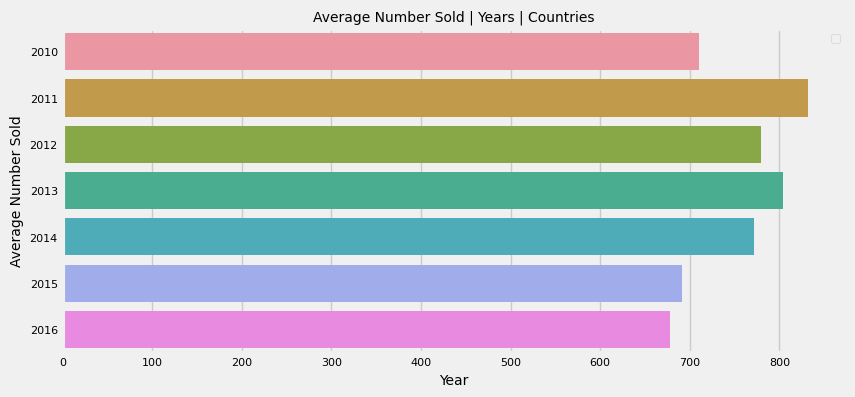

In [19]:
plt.figure(figsize=(9,4))
ax = sns.barplot(data = average_sale_per_year, x = "num_sold", y = "year_fv" )
ax.set_xlabel("Year", fontsize=10)
ax.set_ylabel("Average Number Sold", fontsize=10)
ax.tick_params(axis="both", labelsize=8)
ax.legend(bbox_to_anchor=(1, 1), ncols=1, fontsize=8)
plt.title("Average Number Sold | Years | Countries", size=10)
plt.show()

In [20]:
train_df.nunique().sort_values(ascending=False).reset_index().style.format(precision=2).background_gradient(cmap="Greens")

In [21]:
test_df.nunique().sort_values(ascending=False).reset_index().style.format(precision=2).background_gradient(cmap="Greens")

In [22]:
train_df.isna().sum().reset_index().style.format(precision=2).background_gradient(cmap="Reds")

In [23]:
test_df.isna().sum().reset_index().style.format(precision=2).background_gradient(cmap="Reds")

In [24]:
train_df["store"].value_counts().reset_index().style.format(precision=2).background_gradient(cmap="Reds")

In [25]:
test_df["store"].value_counts().reset_index().style.format(precision=2).background_gradient(cmap="Reds")

In [26]:
train_df["country"].value_counts().reset_index().style.format(precision=2).background_gradient(cmap="YlOrRd")

In [27]:
test_df["country"].value_counts().reset_index().style.format(precision=2).background_gradient(cmap="YlOrRd")

In [28]:
train_df["product"].value_counts().reset_index().style.format(precision=2).background_gradient(cmap="YlOrRd")

In [29]:
test_df["product"].value_counts().reset_index().style.format(precision=2).background_gradient(cmap="YlOrRd")

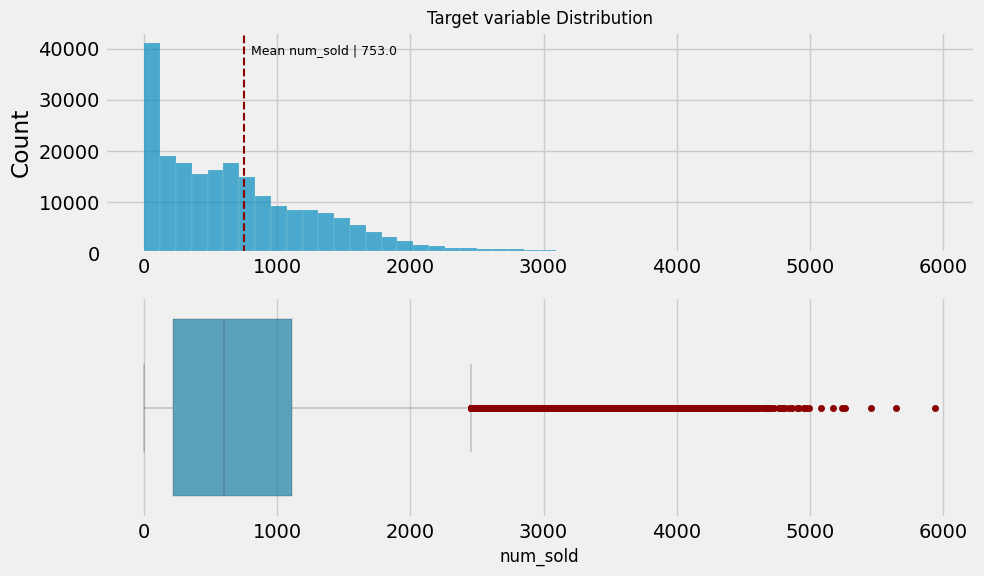

In [30]:
mean_num_sold = train_df[["num_sold"]].mean().squeeze()

fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 6))

sns.histplot(
    data=train_df,
    x="num_sold",
    color="#038BBD",
    bins=50,
    alpha=0.7,
    lw=0.1,
    ax=ax1,
)

sns.boxplot(
    data=train_df,
    x="num_sold",
    color="#038BBD",
    linewidth=0.3,
    flierprops=dict(
        marker="o", markersize=4, markerfacecolor="darkred", markeredgecolor="darkred"
    ),
    boxprops=dict(alpha=0.7),
    ax=ax2,
)
ax2.set_title("")
ax2.set_xlabel("num_sold", fontsize=12)

ax1.set_title("Target variable Distribution", fontsize=12)
ax1.set_xlabel("")

ax1.axvline(x=mean_num_sold, color="darkred", ls="--", lw=1.5)
ax1.text(
    mean_num_sold + 50,
    39000,
    "Mean num_sold | " + str(mean_num_sold.round(0)),
    fontsize=9,
    color="#000000",
)

plt.show()


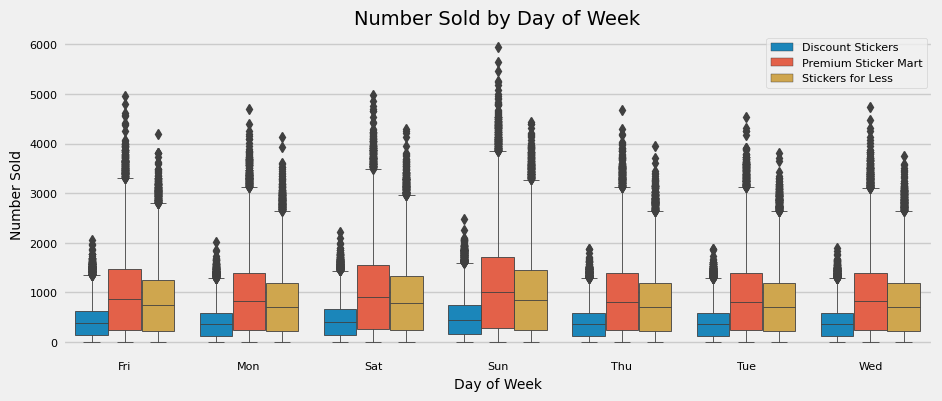

In [31]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.boxplot(data=train_df,
            x='weekday_sv',
            y='num_sold',
            hue='store',
            ax=ax,
            linewidth=0.6)
ax.set_title('Number Sold by Day of Week', fontsize=14)
ax.set_xlabel('Day of Week', fontsize=10)
ax.set_ylabel('Number Sold', fontsize=10)
ax.tick_params(axis="both", labelsize=8)
ax.legend(bbox_to_anchor=(1, 1), ncols=1, fontsize=8)
plt.show()

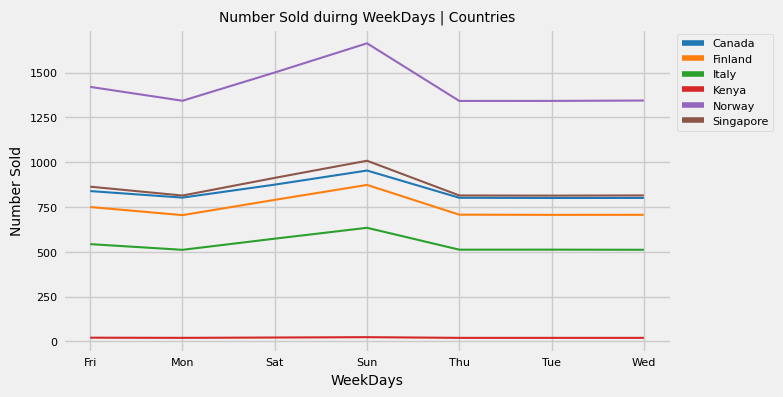

In [32]:
plt.figure(figsize=(7, 4))
ax = sns.lineplot(
    data=train_df,
    x="weekday_sv",
    y="num_sold",
    hue="country",
    errorbar=None,
    linewidth=1.5,
    palette = "tab10"
)
ax.set_xlabel("WeekDays", fontsize=10)
ax.set_ylabel("Number Sold", fontsize=10)
ax.tick_params(axis="both", labelsize=8)
ax.legend(bbox_to_anchor=(1, 1), ncols=1, fontsize=8)
plt.title("Number Sold duirng WeekDays | Countries", size=10)
plt.show()

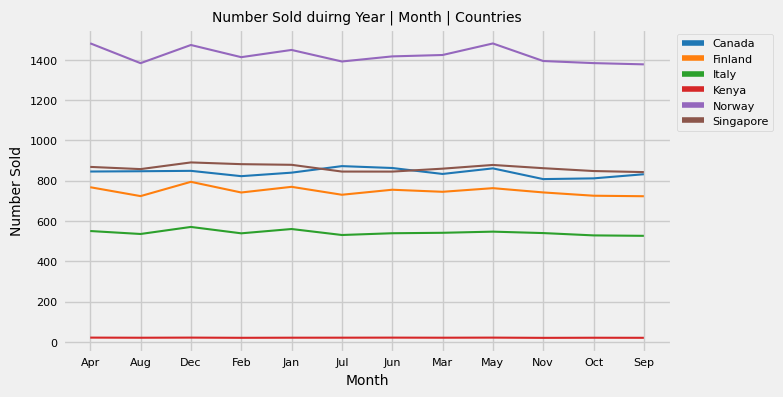

In [33]:
plt.figure(figsize=(7, 4))
ax = sns.lineplot(
    data=train_df,
    x="month_name_sv",
    y="num_sold",
    hue="country",
    errorbar=None,
    linewidth=1.5,
    palette = "tab10"
)
ax.set_xlabel("Month", fontsize=10)
ax.set_ylabel("Number Sold", fontsize=10)
ax.tick_params(axis="both", labelsize=8)
ax.legend(bbox_to_anchor=(1, 1), ncols=1, fontsize=8)
plt.title("Number Sold duirng Year | Month | Countries", size=10)
plt.show()

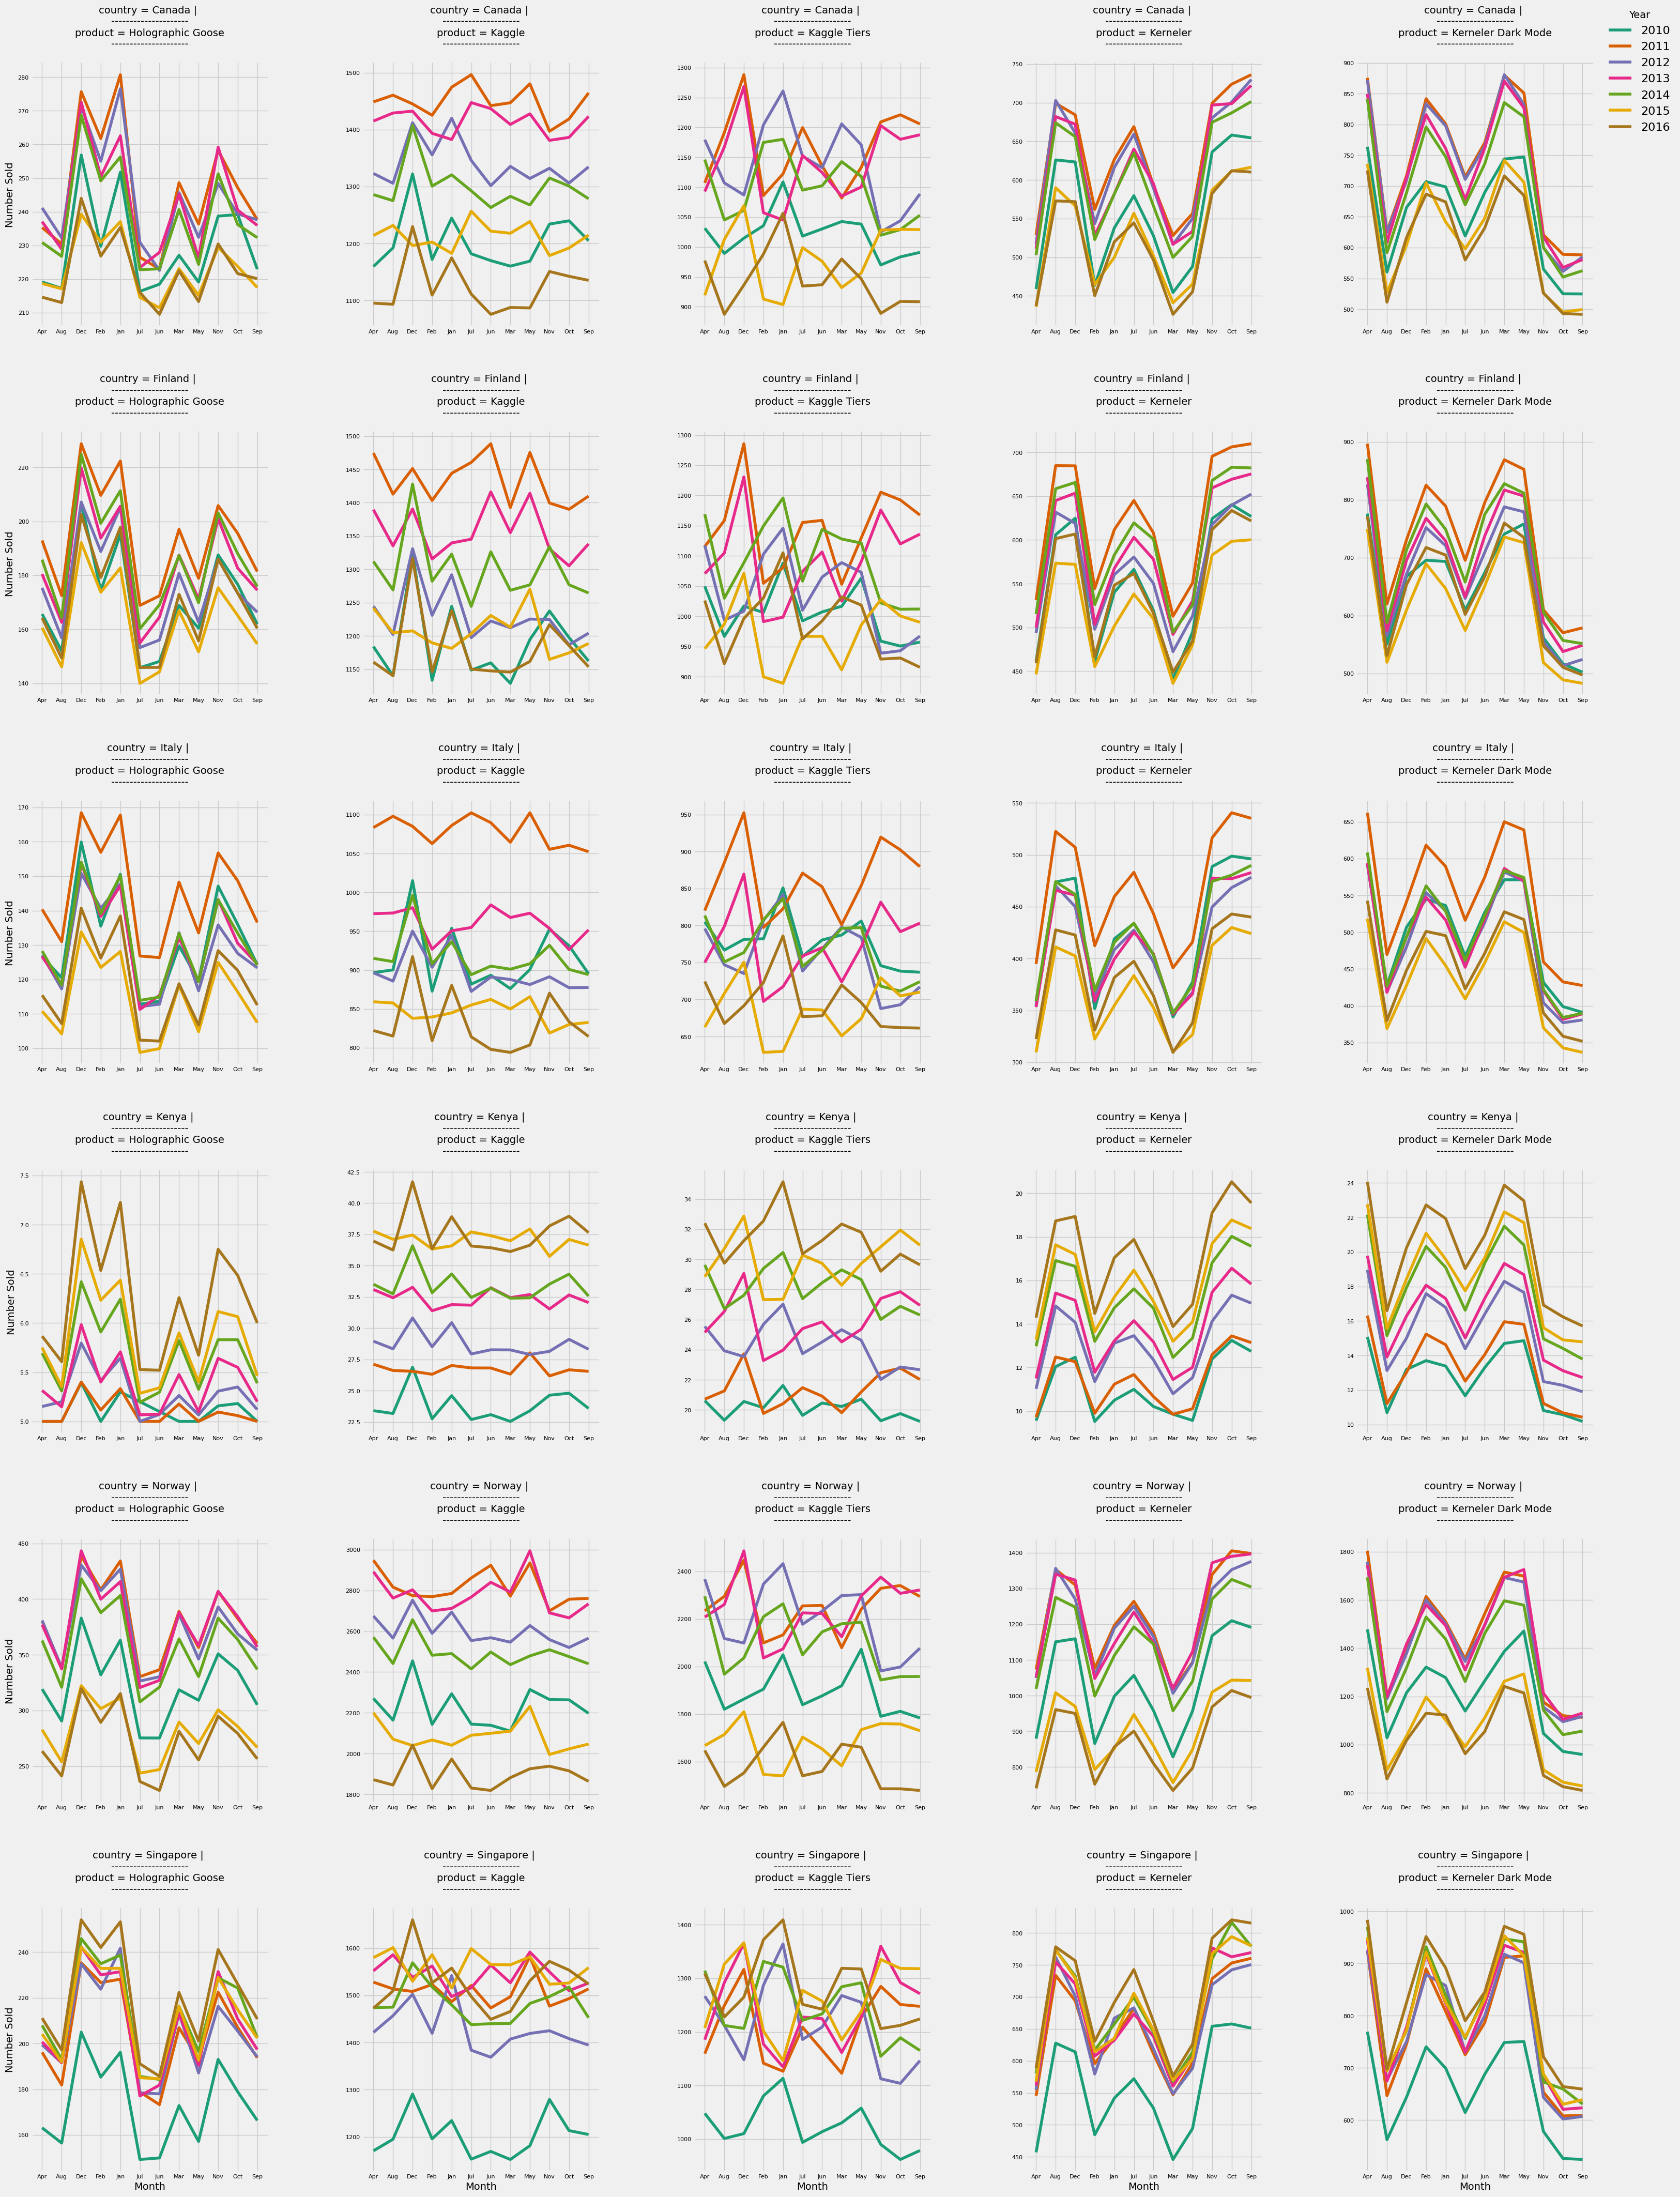

In [34]:
g = sns.FacetGrid(
    train_df,
    row="country",
    hue="year_fv",
    col="product",
    palette = "Dark2",
    height=7,
    aspect=0.9,
    sharey=False,
    sharex=False,
)
g.map(sns.lineplot, "month_name_sv", "num_sold", errorbar=None)
g.set_titles(
        col_template="\n---------------------\n{col_var} = {col_name}\n---------------------\n",
        size=14,
    )

g.add_legend(loc='upper right', title= "Year", fontsize= 16, title_fontsize= 16)
g.tick_params(labelsize=8)
g.set_axis_labels(x_var="Month", y_var="Number Sold", fontsize=14)
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()

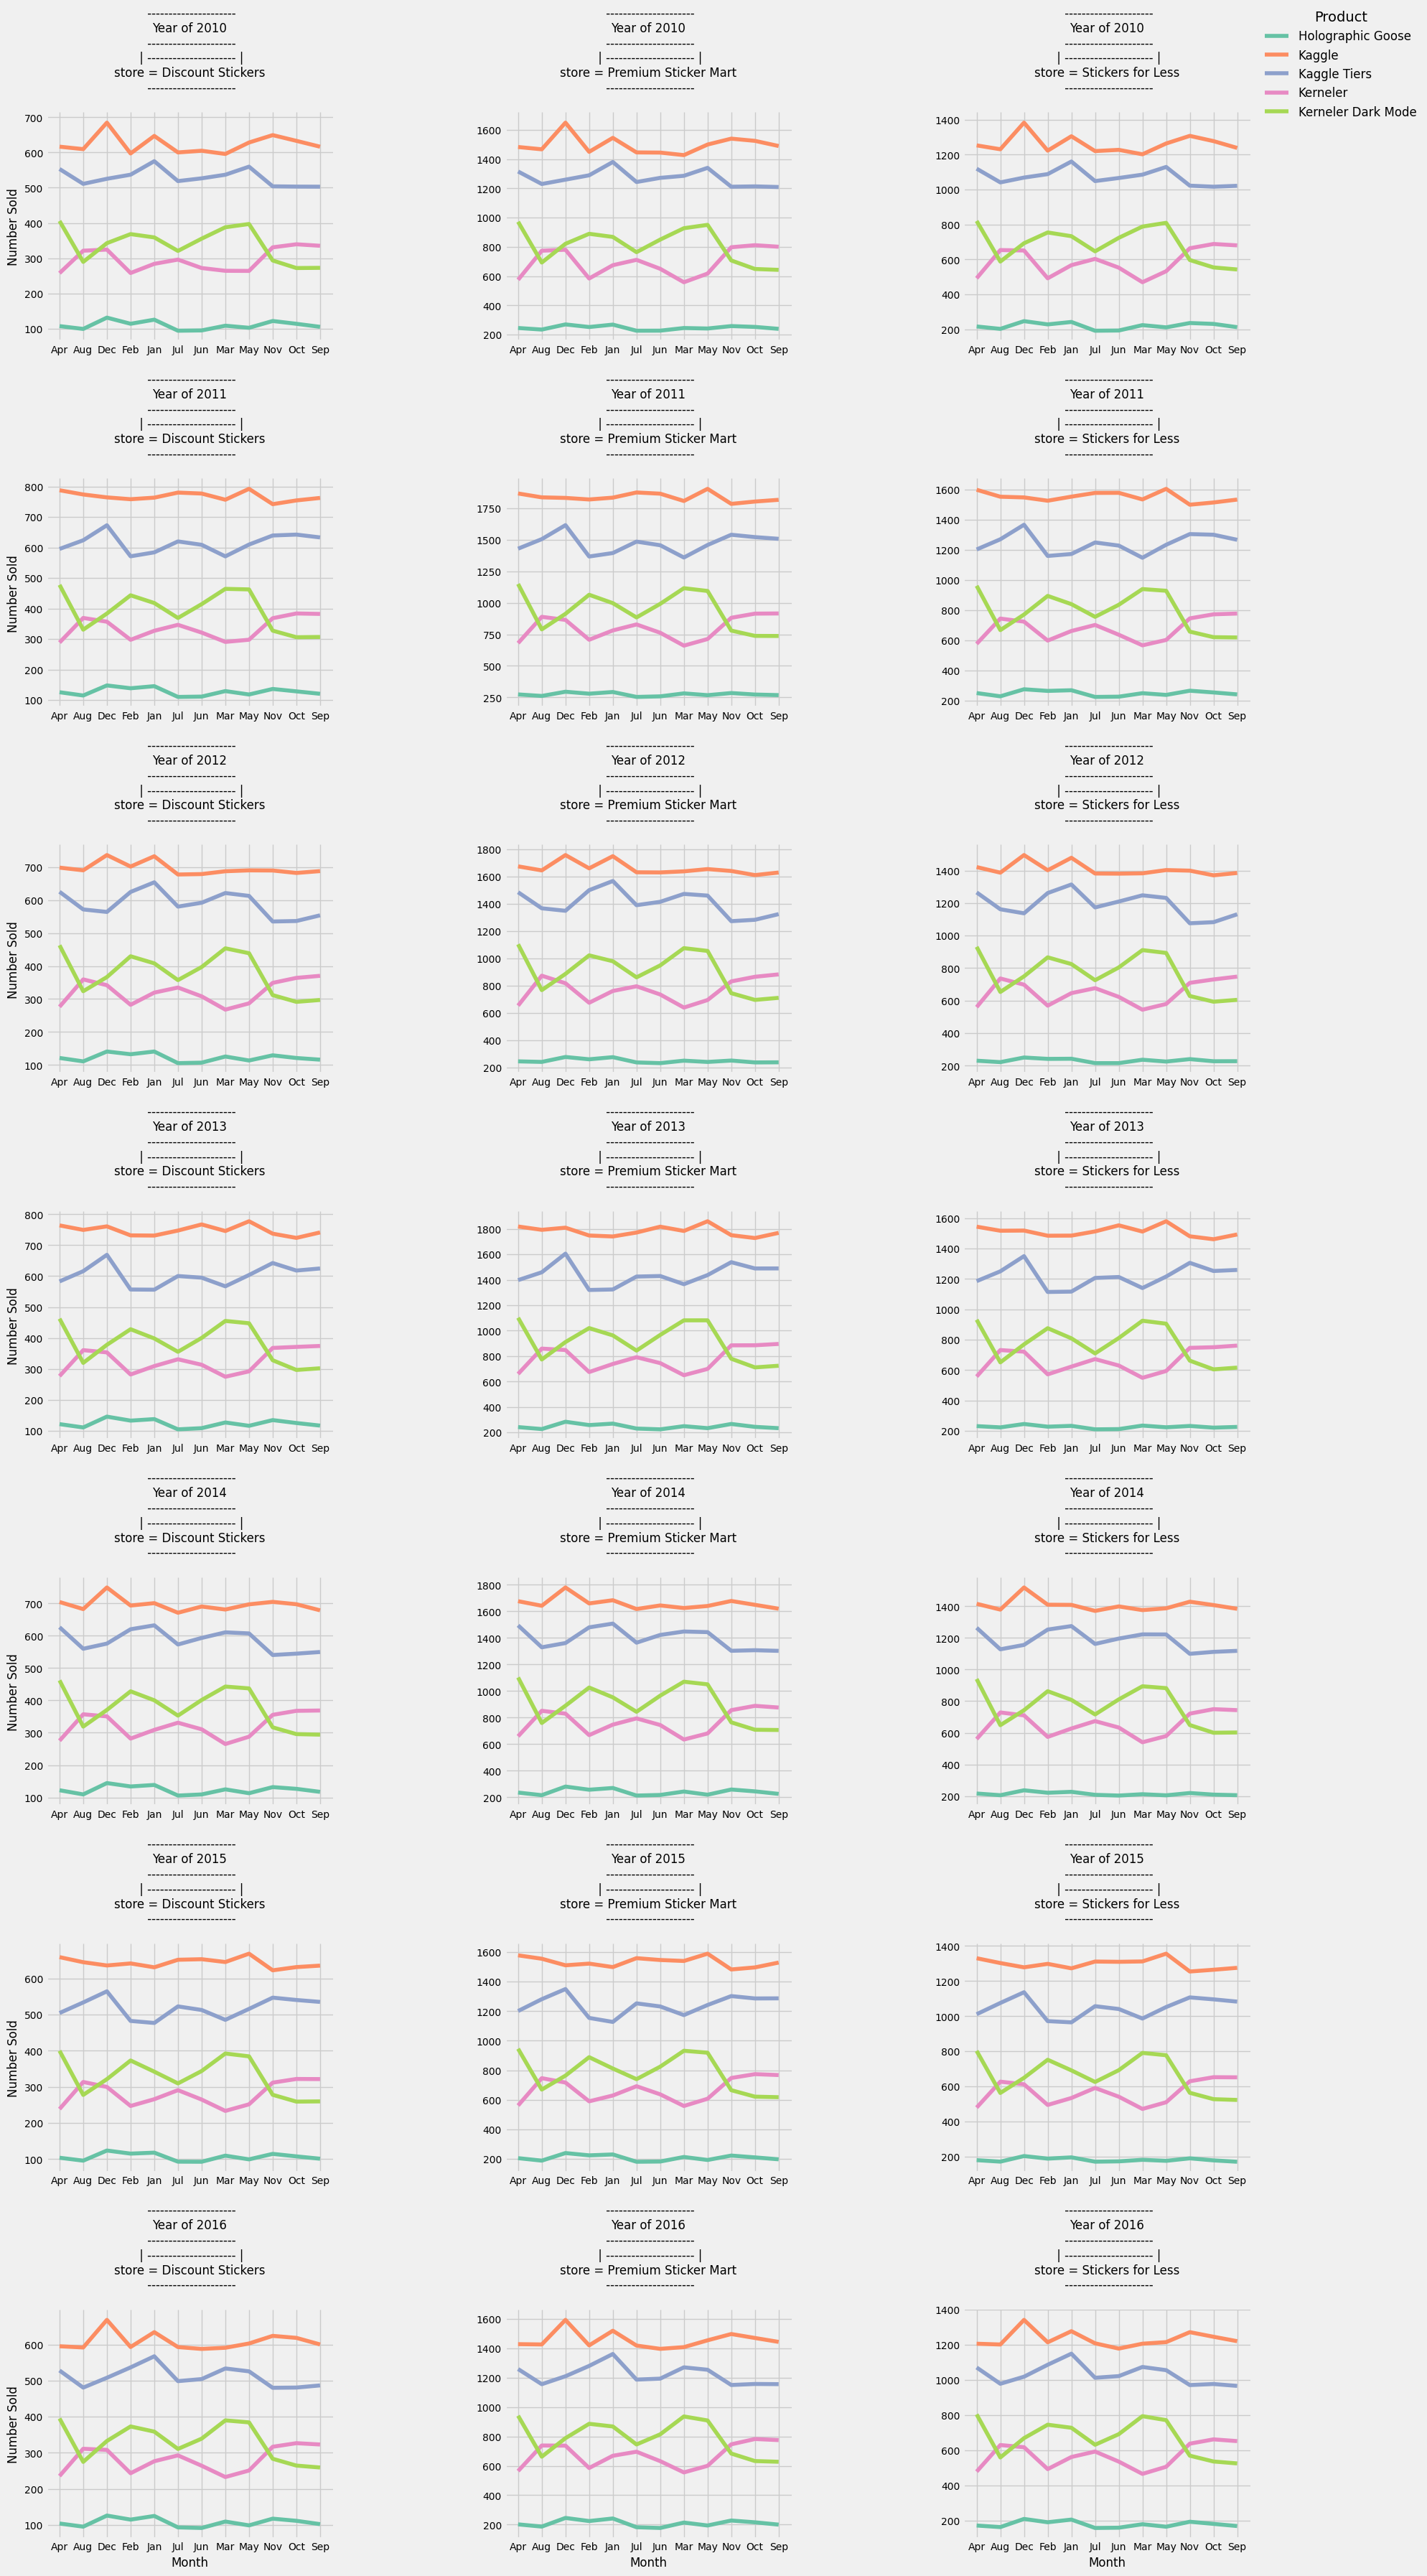

In [35]:
g = sns.FacetGrid(
    train_df,
    row="year_fv",
    hue="product",
    col="store",
    palette = "Set2",
    height=5,
    aspect=1.2,
    sharey=False,
    sharex=False,
)
g.map(sns.lineplot, "month_name_sv", "num_sold", errorbar=None)
g.set_titles(
        row_template=" ---------------------\nYear of {row_name}\n ---------------------\n",
        col_template="--------------------- |\n{col_var} = {col_name}\n ---------------------\n",
        size=12)

g.add_legend(loc='upper right', title= "Product", fontsize= 12, title_fontsize= 12)
g.tick_params(labelsize=10)
g.set_axis_labels(x_var="Month", y_var="Number Sold", fontsize=12)
plt.subplots_adjust(hspace=0.6, wspace=0.6)
plt.show()


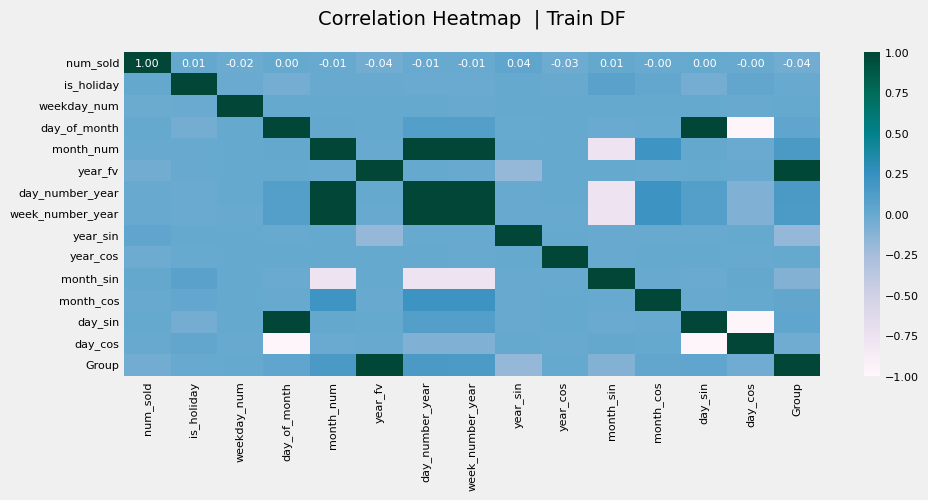

In [36]:
num_vars = train_df.select_dtypes("number").columns.to_list()
fig, ax = plt.subplots(figsize=(10, 4))
sns.heatmap(
    train_df[num_vars].corr(),
    vmin=-1,
    vmax=1,
    annot=True,
    fmt=".2f",
    cmap="PuBuGn",
    annot_kws={"fontsize": 8},
    cbar_kws={"shrink": 1},
    ax = ax
)
cbar_ax = fig.axes[-1]
cbar_ax.tick_params(labelsize=8)
ax.tick_params(labelsize=8)
ax.tick_params(labelsize=8)
plt.title("Correlation Heatmap  | Train DF", fontdict={"fontsize": 14}, pad=20)
plt.show()

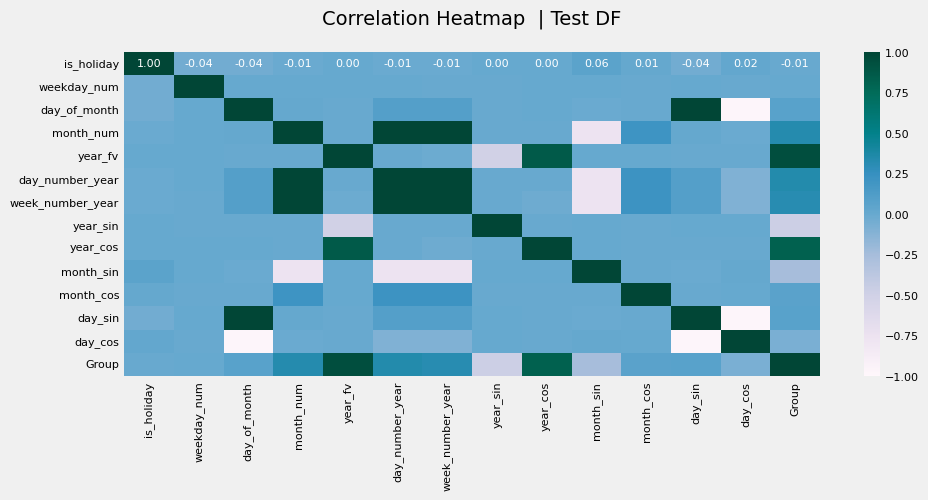

In [37]:
num_vars_test = test_df.select_dtypes("number").columns.to_list()
fig, ax = plt.subplots(figsize=(10, 4))
sns.heatmap(
    test_df[num_vars_test].corr(),
    vmin=-1,
    vmax=1,
    annot=True,
    fmt=".2f",
    cmap="PuBuGn",
    annot_kws={"fontsize": 8},
    cbar_kws={"shrink": 1},
    ax = ax
)
cbar_ax = fig.axes[-1]
cbar_ax.tick_params(labelsize=8)
ax.tick_params(labelsize=8)
ax.tick_params(labelsize=8)
plt.title("Correlation Heatmap  | Test DF", fontdict={"fontsize": 14}, pad=20)
plt.show()

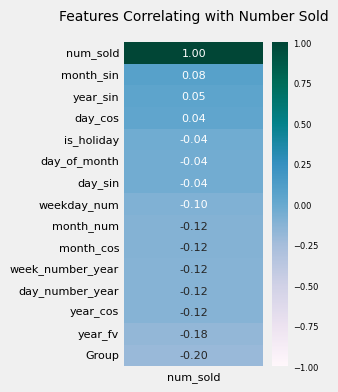

In [38]:
fig, ax = plt.subplots(figsize=(2, 4))
sns.heatmap(
    train_df[num_vars]
    .corr()
    .corr()[["num_sold"]]
    .sort_values(by="num_sold", ascending=False),
    vmin=-1,
    vmax=1,
    annot=True,
    fmt=".2f",
    cmap="PuBuGn",
    annot_kws={"fontsize": 8},
    cbar_kws={"shrink": 1},
    ax = ax
)
cbar_ax = fig.axes[-1]
cbar_ax.tick_params(labelsize=6)
ax.tick_params(labelsize=8)
ax.tick_params(labelsize=8)
ax.set_title(
    "Features Correlating with Number Sold", fontdict={"fontsize": 10}, pad=16
)
plt.show()

In [39]:
X = train_df.drop(columns=["date", "num_sold"], axis = "columns")
y = np.log(train_df["num_sold"])
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=SEED
)

test_df = test_df.drop(columns=["date"])

In [40]:
def lgbm_objective(trial):

    lgbm_params = {
        "n_estimators": 5000,
        "subsample": trial.suggest_float("subsample", 0.3, 0.9),
        "min_child_samples": trial.suggest_int("min_child_samples", 60, 100),
        "max_depth": trial.suggest_int("max_depth", 7, 25),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "lambda_l1": trial.suggest_float("lambda_l1", 0.001, 0.1),
        "lambda_l2": trial.suggest_float("lambda_l2", 0.001, 0.1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0)

    }

    lgbm_model = LGBMRegressor(**lgbm_params, random_state=SEED, verbose=-1)

    lgbm_model.fit(X_train, y_train)
    y_pred = np.exp(lgbm_model.predict(X_test))
    return mean_absolute_percentage_error(np.exp(y_test), y_pred)

In [41]:
study_LGBM = optuna.create_study(study_name="LGBM_Kaggle", direction="minimize")
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_LGBM.optimize(lgbm_objective, n_trials=200, show_progress_bar=True)

[I 2025-01-29 14:46:00,399] A new study created in memory with name: LGBM_Kaggle


  0%|          | 0/200 [00:00<?, ?it/s]

[W 2025-01-29 14:53:22,606] Trial 15 failed with parameters: {'subsample': 0.4145195188499329, 'min_child_samples': 84, 'max_depth': 16, 'learning_rate': 0.01105547969264302, 'lambda_l1': 0.020430012794742415, 'lambda_l2': 0.029415428102967607, 'colsample_bytree': 0.4038807175251904} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\atalb\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\atalb\AppData\Local\Temp\ipykernel_23480\3536774369.py", line 17, in lgbm_objective
    lgbm_model.fit(X_train, y_train)
  File "c:\Users\atalb\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\sklearn.py", line 1189, in fit
    super().fit(
  File "c:\Users\atalb\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\sklearn.py", line 955, in fit
    self._Booster = train(
   

KeyboardInterrupt: 

In [37]:
print("Best trial:", study_LGBM.best_trial)

Best trial: FrozenTrial(number=141, state=TrialState.COMPLETE, values=[0.041779469074445456], datetime_start=datetime.datetime(2025, 1, 28, 13, 15, 20, 569786), datetime_complete=datetime.datetime(2025, 1, 28, 13, 16, 0, 522322), params={'subsample': 0.4135506621244774, 'min_child_samples': 66, 'max_depth': 23, 'learning_rate': 0.05075726182416617, 'lambda_l1': 0.08453477144049343, 'lambda_l2': 0.09337696724054419, 'colsample_bytree': 0.31600563921606745}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'subsample': FloatDistribution(high=0.9, log=False, low=0.3, step=None), 'min_child_samples': IntDistribution(high=100, log=False, low=60, step=1), 'max_depth': IntDistribution(high=25, log=False, low=7, step=1), 'learning_rate': FloatDistribution(high=0.1, log=False, low=0.01, step=None), 'lambda_l1': FloatDistribution(high=0.1, log=False, low=0.001, step=None), 'lambda_l2': FloatDistribution(high=0.1, log=False, low=0.001, step=None), 'colsample_bytree': FloatDi

In [38]:
print("Best parameters:", study_LGBM.best_params)

Best parameters: {'subsample': 0.4135506621244774, 'min_child_samples': 66, 'max_depth': 23, 'learning_rate': 0.05075726182416617, 'lambda_l1': 0.08453477144049343, 'lambda_l2': 0.09337696724054419, 'colsample_bytree': 0.31600563921606745}


In [39]:
train_df_shap = train_df.drop(columns=["date"], axis=1)
X_shap = train_df_shap.drop(["num_sold"], axis=1)
y_shap = np.log(train_df_shap["num_sold"])
X_train_shap, X_test_shap, y_train_shap, y_test_shap = train_test_split(
    X_shap, y_shap, train_size=0.3, random_state=SEED
)
X_display, y_display = X_train_shap, y_train_shap

lgbm_interp = LGBMRegressor(
    **study_LGBM.best_params,
    objective= "regression",
    metric= "rmse",
    n_estimators= 500,
    random_state=SEED,
    verbose=-1
)
lgbm_interp.fit(X_train_shap, y_train_shap)
shap.initjs()
explainer = shap.TreeExplainer(lgbm_interp)
shap_values = explainer(X_train_shap)


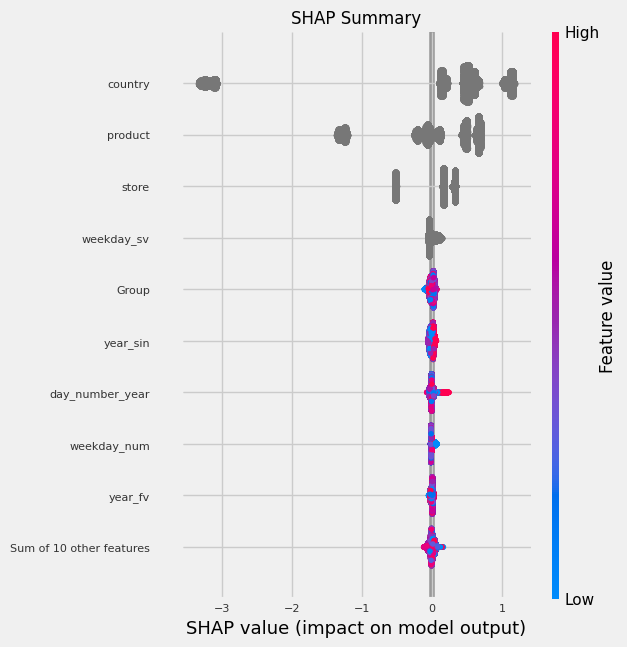

In [40]:
shap.plots.beeswarm(
    shap_values,
    show=False,
)
fig, ax = plt.gcf(), plt.gca()
fig.set_figheight(7)
fig.set_figwidth(5)
ax.tick_params(labelsize=8)
ax.set_title("SHAP Summary", fontsize=12)
plt.show()

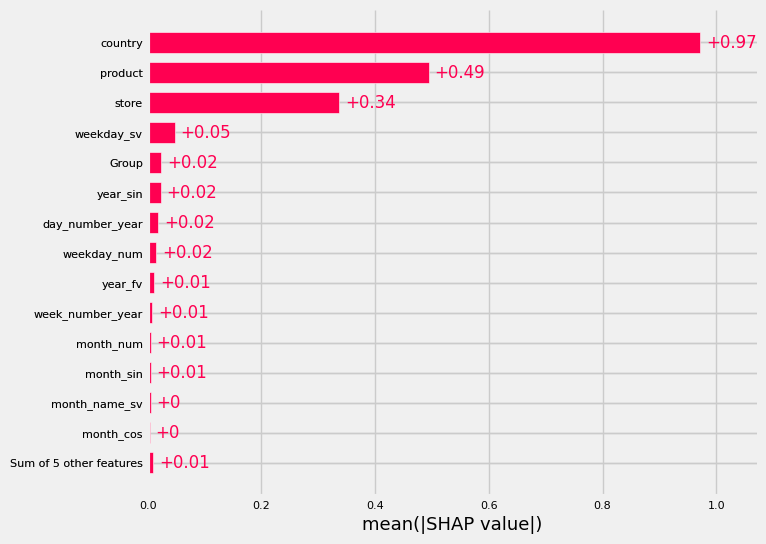

In [41]:
shap.plots.bar(shap_values, max_display=15, show=False)
fig, ax = plt.gcf(), plt.gca()
fig.set_figheight(6)
fig.set_figwidth(7)
ax.tick_params(labelsize=8)
plt.show()

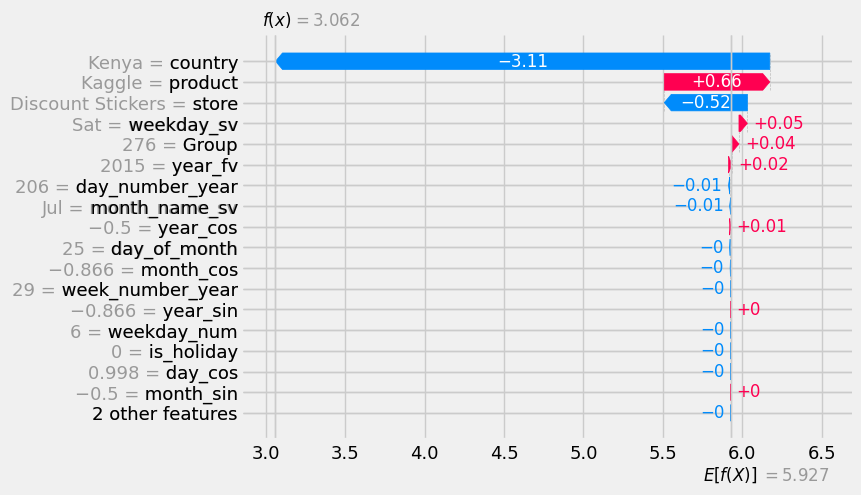

In [42]:
index = 100
shap.plots.waterfall(shap_values[index], max_display=18,  show=False)
fig, ax = plt.gcf(), plt.gca()
fig.set_figheight(5)
fig.set_figwidth(7)
plt.show()

In [43]:
lgbm_final = LGBMRegressor(
    **study_LGBM.best_params,
    n_estimators= 5000,
    random_state=SEED,
    verbose=-1
)
lgbm_final.fit(X_train, y_train)
y_pred = np.exp(lgbm_final.predict(X_test))
print("MAPE:",mean_absolute_percentage_error(np.exp(y_test), y_pred))

MAPE: 0.041779469074445456


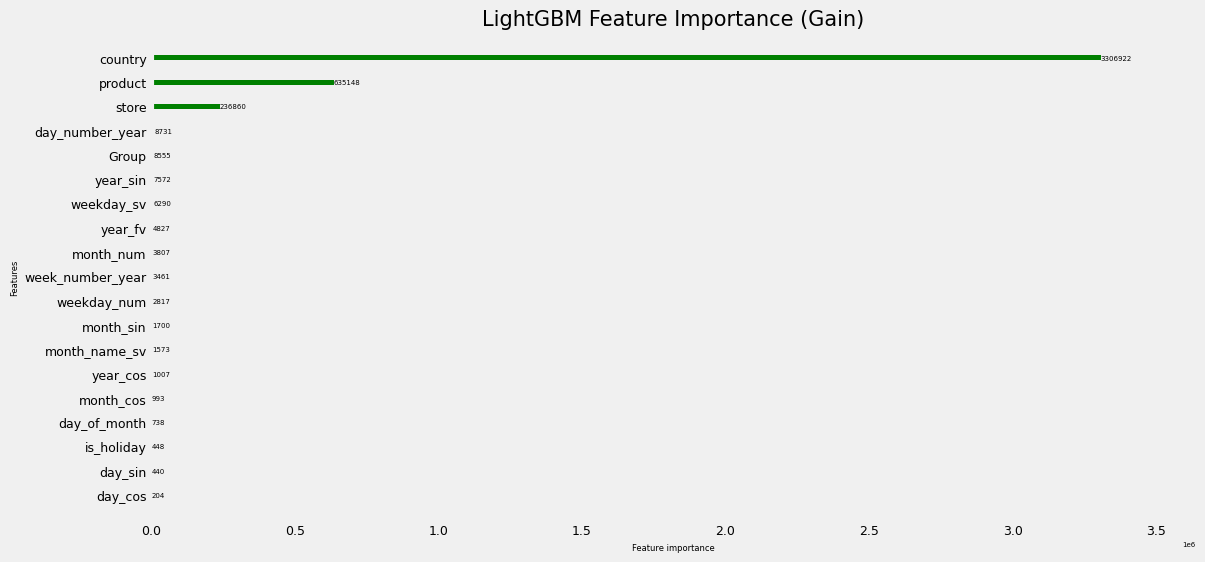

In [44]:
plt.rcParams["font.size"] = 5
lgb.plot_importance(
    lgbm_final,
    importance_type="gain",
    figsize=(12, 6),
    precision=0,
    grid=False,
    color="green",
)

plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.title("LightGBM Feature Importance (Gain)", fontsize=15)
plt.show()
plt.rcParams.update(plt.rcParamsDefault)

In [45]:
y_pred_test = lgbm_final.predict(test_df)
y_pred_test

array([4.87927387, 6.69576779, 6.48662738, ..., 7.51839629, 6.95140632,
       7.12873909])

In [46]:
sample_submission["num_sold"] = np.exp(y_pred_test)

sample_submission.to_csv("submission.csv", index=False)
sample_submission

id     num_sold
0      230130   131.535117
1      230131   808.974821
2      230132   656.306157
3      230133   358.764203
4      230134   433.197452
...       ...          ...
98545  328675   371.571608
98546  328676  2366.065860
98547  328677  1841.611519
98548  328678  1044.617764
98549  328679  1247.303235

[98550 rows x 2 columns]